In [1]:
from apps.onedimensional.shallowwater import shallow_water as sw
from apps.onedimensional.shallowwater.manufacturedsolutionexample import manufactured_solution_example as sw_mse
from pydogpack import main
from pydogpack.tests.utils import utils
from pydogpack.timestepping import explicit_runge_kutta
from pydogpack.utils import dg_utils
from pydogpack.utils import math_utils
from pydogpack.utils import x_functions
from pydogpack.utils import xt_functions
from pydogpack.visualize import plot

import numpy as np
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10]

from IPython.display import HTML

# Manufactured Solution

In [54]:
gravity_constant = 1.0
include_v = True

# q1 = xt_functions.AdvectingSine(0.05, 1.0, 1.0, 0.0, 1.0)
# q2 = xt_functions.AdvectingSine(0.05, 1.0, 0.0, 0.0, 1.0)
# q3 = xt_functions.AdvectingSine(0.05, 1.0, 0.0, 0.0, 1.0)

q1 = xt_functions.AdvectingPeriodicGaussian(0.1, 8.0, 1.0, 0.4, 1.0, 1.0)
q2 = xt_functions.AdvectingPeriodicGaussian(0.1, 8.0, 1.0, 0.4, 0.0, 1.0)
q3 = xt_functions.AdvectingPeriodicGaussian(0.1, 8.0, 1.0, 0.4, 0.0, 1.0)
list_ = [q1, q2]
if include_v:
    list_.append(q3)
exact_solution = xt_functions.ComposedVector(list_)

max_wavespeed = 0.1 + np.sqrt(gravity_constant * 1.1)

problem = sw_mse.ManufacturedSolutionExample(
    exact_solution,
    max_wavespeed,
    gravity_constant,
    include_v,
)

time_final = 0.2
problem.parameters["time_final"] = time_final
problem.parameters["is_weak"] = True

space_time_order = 4
problem.parameters["time_stepping"]["time_stepping_class"] = "explicit_runge_kutta"
problem.parameters["time_stepping"]["is_verbose"] = True
problem.parameters["time_stepping"]["num_frames"] = 5
problem.parameters["time_stepping"]["order"] = space_time_order

num_elems = 20
x_left = 0.0
x_right = 1.0
problem.parameters["mesh"]["mesh_class"] = "mesh_1d_uniform"
problem.parameters["mesh"]["x_left"] = x_left
problem.parameters["mesh"]["x_right"] = x_right
problem.parameters["mesh"]["num_elems"] = num_elems

problem.parameters["basis"]["basis_class"] = "legendre"
problem.parameters["basis"]["inner_product_constant"] = 0.5
problem.parameters["basis"]["num_basis_cpts"] = space_time_order

problem.parameters["boundary_condition"]["boundary_condition_class"] = "periodic"
problem.parameters["riemann_solver"]["riemann_solver_class"] = "local_lax_friedrichs"

cfl = explicit_runge_kutta.get_cfl(space_time_order)
#cfl = 0.5
delta_x = (x_right - x_left) / num_elems
delta_t = float(dg_utils.get_delta_t(cfl, problem.max_wavespeed, delta_x))
problem.parameters["delta_t"] = delta_t

problem._setup_objects()

In [55]:
final_solution = main.run(problem)

20.0%
Will finish in 0:00:07.685708 at 14:39:09.727456
40.0%
Will finish in 0:00:05.754754 at 14:39:09.711578
60.0%
Will finish in 0:00:03.853867 at 14:39:09.754988
80.0%
Will finish in 0:00:01.940985 at 14:39:09.825247
100.0%
Will finish in 0:00:00 at 14:39:09.794580


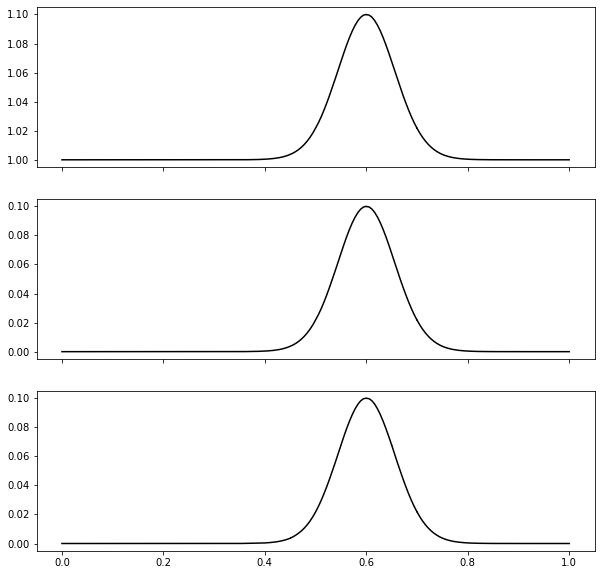

In [56]:
exact_final_solution = x_functions.FrozenT(problem.exact_solution, time_final)
exact_final_height = x_functions.FrozenT(list_[0], time_final)
exact_final_momentum = x_functions.FrozenT(list_[1], time_final)
fig = plot.create_plot_dg_1d(final_solution)
#lines = plot.plot_function(fig.axes, exact_final_solution, x_left, x_right, style='b')

#ani, fig = plot.create_animation_output_dir(problem.output_dir, problem.exact_solution)
#HTML(ani.to_html5_video())

In [49]:
error = math_utils.compute_error(final_solution, exact_final_solution)
error

0.0002046227259031517

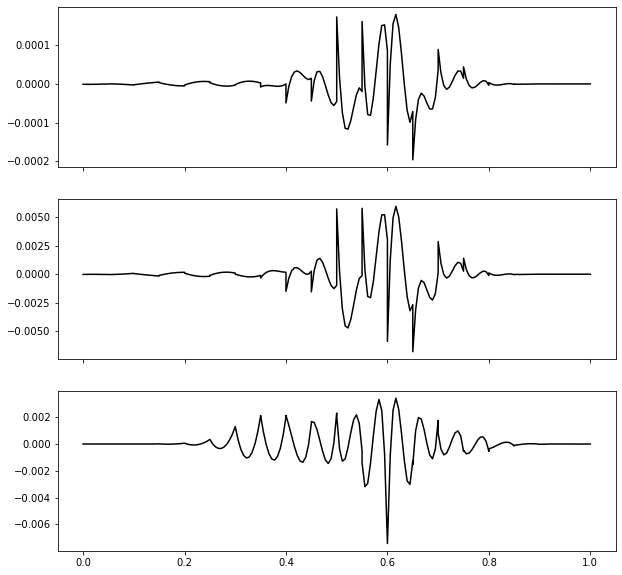

In [30]:
dg_error = math_utils.compute_dg_error(final_solution, exact_final_solution)
p = dg_error.create_plot()

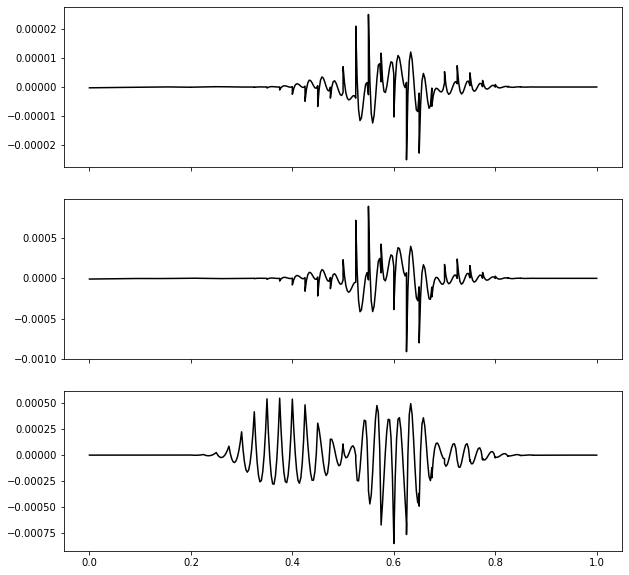

In [35]:
dg_error = math_utils.compute_dg_error(final_solution, exact_final_solution)
p = dg_error.create_plot()

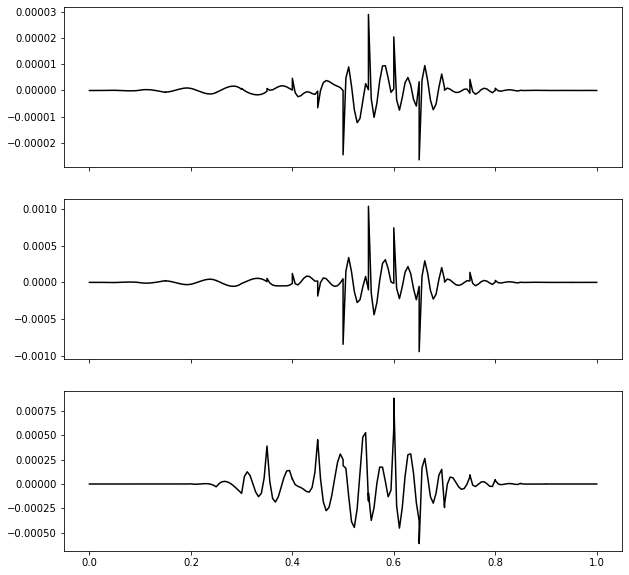

In [57]:
dg_error = math_utils.compute_dg_error(final_solution, exact_final_solution)
p = dg_error.create_plot()

## Convergence Test

In [20]:
gravity_constant = 1.0
include_v = True

# q1 = xt_functions.AdvectingSine(0.01, 1.0, 1.0, 0.0, 1.0)
# q2 = xt_functions.AdvectingSine(0.01, 1.0, 0.0, 0.0, 1.0)
# q3 = xt_functions.AdvectingSine(0.01, 1.0, 0.0, 0.0, 1.0)

q1 = xt_functions.AdvectingPeriodicGaussian(0.1, 5.0, 1.0, 0.4, 1.0, 1.0)
q2 = xt_functions.AdvectingPeriodicGaussian(0.1, 5.0, 1.0, 0.4, 0.0, 1.0)
q3 = xt_functions.AdvectingPeriodicGaussian(0.1, 5.0, 1.0, 0.4, 0.0, 1.0)
list_ = [q1, q2]
if include_v:
    list_.append(q3)
exact_solution = xt_functions.ComposedVector(list_)

max_wavespeed = 0.1 + np.sqrt(gravity_constant * 1.1)

problem = sw_mse.ManufacturedSolutionExample(
    exact_solution,
    max_wavespeed,
    gravity_constant,
    include_v,
)

time_final = 0.2
exact_final_solution = x_functions.FrozenT(problem.exact_solution, time_final)
problem.parameters["time_final"] = time_final
problem.parameters["is_weak"] = True

problem.parameters["time_stepping"]["time_stepping_class"] = "explicit_runge_kutta"
problem.parameters["time_stepping"]["is_verbose"] = False
problem.parameters["time_stepping"]["num_frames"] = 10

x_left = 0.0
x_right = 1.0
problem.parameters["mesh"]["mesh_class"] = "mesh_1d_uniform"
problem.parameters["mesh"]["x_left"] = x_left
problem.parameters["mesh"]["x_right"] = x_right

problem.parameters["basis"]["basis_class"] = "legendre"
problem.parameters["basis"]["inner_product_constant"] = 0.5

problem.parameters["boundary_condition"]["boundary_condition_class"] = "periodic"
problem.parameters["riemann_solver"]["riemann_solver_class"] = "local_lax_friedrichs"

In [21]:
for num_basis_cpts in range(3, 4):
    problem.parameters["basis"]["num_basis_cpts"] = num_basis_cpts
    problem.parameters["time_stepping"]["order"] = num_basis_cpts
    
    cfl = explicit_runge_kutta.get_cfl(num_basis_cpts)
    error_list = []
    final_solution_list = []
    for num_elems in [20, 40]:
        delta_x = (x_right - x_left) / num_elems
        delta_t = float(dg_utils.get_delta_t(cfl, problem.max_wavespeed, delta_x))
        problem.parameters["delta_t"] = delta_t
        problem.parameters["mesh"]["num_elems"] = num_elems
        
        problem._setup_objects()
        final_solution = main.run(problem)
        final_solution_list.append(final_solution)
        
        error = math_utils.compute_error(final_solution, exact_final_solution)
        error_list.append(error)
    order = utils.convergence_order(error_list)
    print(order)
    print(error_list)
    if error_list[-1] >= math_utils.MACHINE_ERROR:
        assert np.round(order) >= num_basis_cpts

2.5591990540040053
[0.0037602518829048196, 0.0006380008499155304]


In [22]:
dg_error_list = [math_utils.compute_dg_error(final_solution, exact_final_solution) for final_solution in final_solution_list]

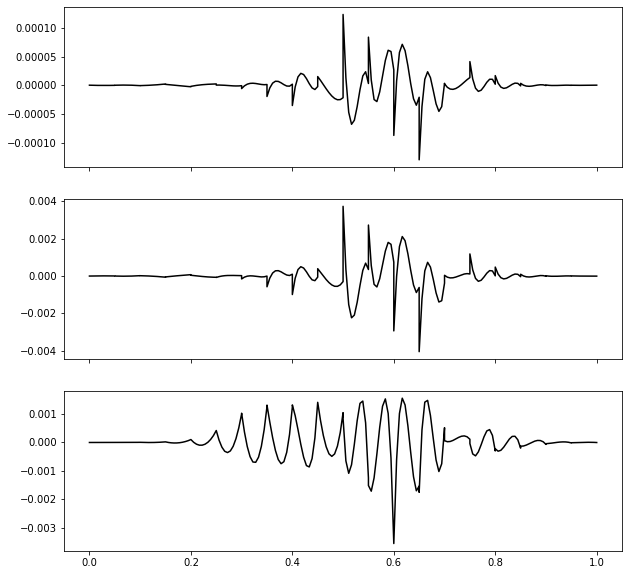

In [23]:
p = dg_error_list[0].create_plot()

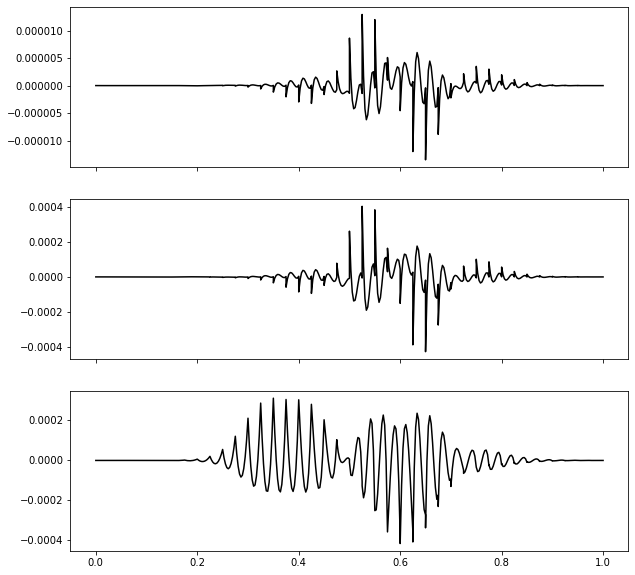

In [24]:
p = dg_error_list[1].create_plot()

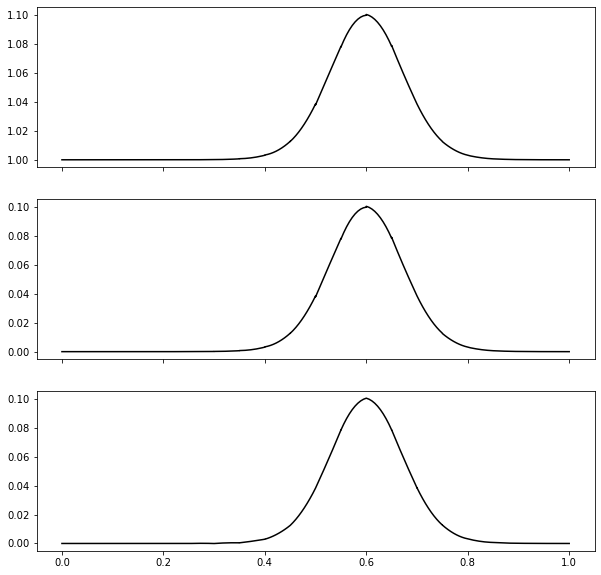

In [25]:
p = final_solution_list[0].create_plot()